# Prepare environment

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../data"))

# Any results you write to the current directory are saved as output.

['train', 'sample_submission.csv', 'test_randompick.csv', '.ipynb_checkpoints', 'test', 'train.csv']


In [2]:
!pip install albumentations --user > /dev/null 2>&1

In [3]:
!pip install pretrainedmodels --user > /dev/null 2>&1

In [4]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

from collections import OrderedDict
import cv2
import albumentations
from albumentations import torch as AT
import pretrainedmodels
import csv


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Prepare data

In [6]:
train_df = pd.read_csv("../data/train.csv")
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [9]:
print(f"There are {len(os.listdir('../data/train'))} images in train dataset with {train_df.Id.nunique()} unique classes.")
#print(f"There are {len(os.listdir('../data/test'))} images in test dataset with {test_df.Id.nunique()} unique classes.")
    

There are 25362 images in train dataset with 5005 unique classes.


In [10]:
train_df.Id.value_counts().head()

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

In [11]:
for i in range(1, 4):
    print(f'There are {train_df.Id.value_counts()[train_df.Id.value_counts().values==i].shape[0]} classes with {i} samples in train data.')

There are 2073 classes with 1 samples in train data.
There are 1285 classes with 2 samples in train data.
There are 568 classes with 3 samples in train data.


In [12]:
len(train_df.Id)

25361

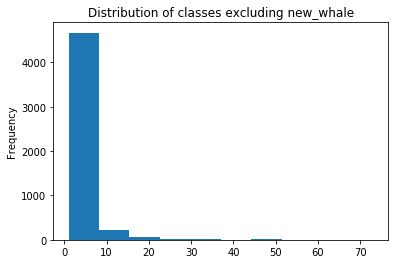

In [13]:
train_df.Id.value_counts()[1:].plot(kind='hist');
plt.title('Distribution of classes excluding new_whale');

In [21]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [22]:
y, le = prepare_labels(train_df['Id'])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# Prepare Network

### Simple CNN

In [32]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx - 1][0])
            label = self.y[idx - 1]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx - 1])
            label = np.zeros((4571,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]
        

In [33]:
data_transforms = transforms.Compose([
                                      transforms.Resize((100, 100)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.Resize((100, 100)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])


In [43]:
train_dataset = WhaleDataset(datafolder='../data/train/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='../data/test/', datatype='test', transform=data_transforms_test)

train_sampler = SubsetRandomSampler(list(range(len(os.listdir('../data/train')))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('../data/test')))))
batch_size = 512
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
# less size for test loader.
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)


In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 7, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)        
        self.pool2 = nn.AvgPool2d(3, 3)
        
        self.fc1 = nn.Linear(64 * 4 * 4 * 16, 1024)
        self.fc2 = nn.Linear(1024, 5005)

        self.dropout = nn.Dropout(0.5)        

    def forward(self, x):
        x = self.pool(F.relu(self.conv2_bn(self.conv1(x))))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [36]:
model_conv = Net()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Resnet 18

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [ ]:
model_conv = ResNet(ResidualBlock)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Transfer Learning

### Run this before TRAIN

In [50]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx - 1][0])
            label = self.y[idx - 1]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx - 1])
            label = np.zeros((5005,))

        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.transform(image=img)
        image = image['image']
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

In [51]:
data_transforms = albumentations.Compose([
    albumentations.Resize(160, 320),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.JpegCompression(80),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(160, 320),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

train_dataset = WhaleDataset(datafolder='../data/train/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='../data/test/', datatype='test', transform=data_transforms_test)

train_sampler = SubsetRandomSampler(list(range(len(os.listdir('../data/train')))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('../data/test')))))
batch_size = 10
num_workers = 0
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
#valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, num_workers=num_workers)


In [52]:
model_conv = pretrainedmodels.resnext101_64x4d()
model_conv.avg_pool = nn.AvgPool2d((5,10))
model_conv.last_linear = nn.Linear(model_conv.last_linear.in_features, 5005)

In [53]:
model_conv.cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train

### Every model use the same one

In [ ]:
model_conv.cuda()
n_epochs = 10
acc = [0] * (n_epochs + 1)
total = list(0. for i in range(train_df.Id.nunique()))
correct = list(0. for i in range(train_df.Id.nunique()))
llloss = [0] * (n_epochs + 1)

for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    valid_loss = []
    exp_lr_scheduler.step()
    accuracy = []
    
    # train
    for batch_i, (data, target) in enumerate(train_loader):
        #print(batch_i)
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        predicted = torch.argmax(output, 1)

        res = (predicted == torch.argmax(target, 1)).squeeze()
        
        for label_idx in range(len(target)):
            
            label_single = torch.argmax(target, 1)[label_idx]
            correct[label_single] += res[label_idx].item()
            total[label_single] += 1

        
        loss = criterion(output, target.float())
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        
    llloss[epoch] = np.mean(train_loss)
    acc[epoch] = sum(correct)/sum(total)
    print(f'Epoch {epoch}, train loss: {llloss[epoch]}, acc : {acc[epoch]}')
    
acc_base_train = acc
loss_base_train = llloss

Mon May 27 21:12:47 2019 Epoch: 1


### Plot

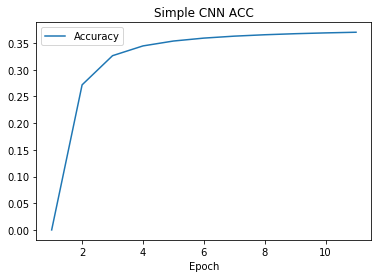

<Figure size 432x288 with 0 Axes>

In [38]:
epoch = range(1, n_epochs + 2)
plt.plot(epoch, acc_base_train, label = 'Accuracy')

plt.xlabel('Epoch')
plt.title('Simple CNN ACC')
plt.legend()
plt.show()
plt.savefig(f'../result/Simple_Transfer_ACC_{time.ctime()}.jpg')#,dpi = 900)


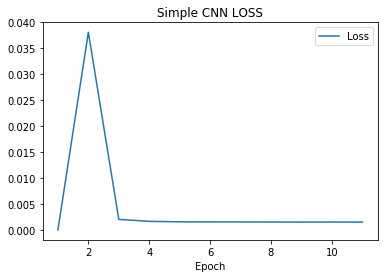

<Figure size 432x288 with 0 Axes>

In [39]:
plt.plot(epoch, loss_base_train, label = 'Loss')
plt.xlabel('Epoch')
plt.title('Simple CNN LOSS')
plt.legend()
plt.show()
plt.savefig(f'../result/Simple_Transfer_LOSS_{time.ctime()}.jpg')#,dpi = 900)


### Get test result

In [44]:
sub = pd.read_csv('../data/sample_submission.csv')

model_conv.eval()
for (data, target, name) in test_loader:
    data = data.cuda()
    output = model_conv(data)
    output = output.cpu().detach().numpy()
    for i, (e, n) in enumerate(list(zip(output, name))):
        sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le.inverse_transform(e.argsort()[-5:][::-1]))
        
sub.to_csv(f'../result/submission_Transfer_{time.ctime()}.csv', index=False)